We first import the necessary packages and load and clean the data sets that we will be using

In [104]:
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator as LNDI
import itertools
import keras
import tensorflow as tf

In [105]:
volsurf_df=pd.read_csv("C:\\Users\\PABLO\\Documents\\GitHub\\Topics-in-Quant-Finance\\implied vol with delta\\Nasdaq_vol_data.csv")
zero_curve=pd.read_csv("C:\\Users\\PABLO\\Documents\\GitHub\\Topics-in-Quant-Finance\\implied vol with delta\\Zero Coupon Curve.csv")


In [106]:
#options with less than 10 days to expiry have no implied volatility calculated
volsurf_df = volsurf_df[(volsurf_df['days'] != 10) & (volsurf_df['days'] <= 365)] #shouldnt then this be <= 10 or use dropna
volsurf_df = volsurf_df.drop(columns=['index_flag','secid'])

#scale delta to be between 0 and 1
volsurf_df['delta'] = volsurf_df['delta']/100

#interest measured in percentage or basis points?
zero_curve['rate'] = zero_curve['rate']/100

In [107]:
impl_vol_sample = volsurf_df[volsurf_df['date']=='2021-12-31']

In [108]:
impl_vol_sample

,date,days,delta,impl_volatility,cp_flag,ticker
1035062,2021-12-31,30,0.10,0.157793,C,NDX
1035063,2021-12-31,30,0.15,0.156618,C,NDX
1035064,2021-12-31,30,0.20,0.157671,C,NDX
1035065,2021-12-31,30,0.25,0.160346,C,NDX
1035066,2021-12-31,30,0.30,0.163933,C,NDX
...,...,...,...,...,...,...
1035193,2021-12-31,365,0.70,0.272167,C,NDX
1035194,2021-12-31,365,0.75,0.284230,C,NDX
1035195,2021-12-31,365,0.80,0.301996,C,NDX
1035196,2021-12-31,365,0.85,0.325403,C,NDX


For this particular date we create a grid with time to maturities($\tau$) and strike ($K$).

In [109]:
zero_curve_sample = zero_curve[zero_curve['date'] == '2021-12-31']
zero_curve_sample = zero_curve_sample[zero_curve_sample['days'].isin([30,60,91,122,152,182,273,365])]

In [110]:
impl_vol_sample = pd.merge(impl_vol_sample,zero_curve_sample[['days','rate']], how='left', left_on='days', right_on='days')

In [111]:
impl_vol_sample.head()

,date,days,delta,impl_volatility,cp_flag,ticker,rate
0,2021-12-31,30,0.10,0.157793,C,NDX,0.005311
1,2021-12-31,30,0.15,0.156618,C,NDX,0.005311
2,2021-12-31,30,0.20,0.157671,C,NDX,0.005311
3,2021-12-31,30,0.25,0.160346,C,NDX,0.005311
4,2021-12-31,30,0.30,0.163933,C,NDX,0.005311


In [112]:
#back out moneyness from delta
def inverse_delta(delta,tao,r,sigma):
    '''
    Calculate the moneyness of the option given: 
    - delta the BS delta, 
    - tao   time to expiry, 
    - sigma implied vol, 
    - r     interest rate.
    '''
    d1 = ndtri(delta)
    expr = d1 * sigma * np.sqrt(tao) - tao * (r + sigma**2 / 2)
    m = np.exp(-expr)
    return m

impl_vol_sample['moneyness']=impl_vol_sample.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

We now create a grid for the volatility surface given moneyness and time to maturity.

In [113]:
#We now create the grid
m_grid=np.linspace(0.6,1.4,10)
t_grid=[30,60,91,122,152,182,273,365]


#Interpolate first in moneyness
impl_vol_sample.sort_values(['days','moneyness'],inplace=True)
interpolated_points=[]
interpolated_df=pd.DataFrame()

for t in t_grid:
    sub_df=impl_vol_sample[impl_vol_sample['days']==t]
    f=interpolate.interp1d(sub_df['moneyness'],sub_df['impl_volatility'],fill_value='extrapolate')
    
    #use structure of sub_df to set up new data frame of interpolated points
    sub_df=sub_df[:10]
    interpolated_points=f(m_grid)
    
    #replace columns for new interpolated grid
    sub_df['moneyness']=m_grid
    sub_df['impl_volatility']=interpolated_points
    
    interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
    interpolated_df.drop(columns=['delta'],inplace=True) #no longer in order
    
    
#interpolation here seems somewhat strange, paper also says to interpolate in time to maturity, but we already have this?



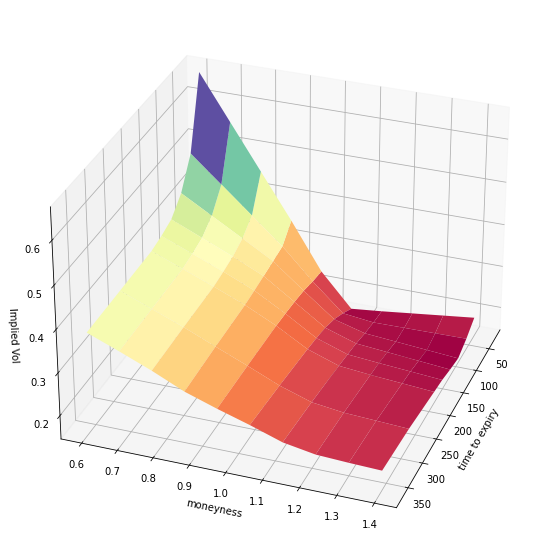

In [114]:
#create surface

tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=20)
plt.show()

In [115]:
def interpolate_impliedvol(moneyness, tau, df):
    """
    Calculate implied volatility by linear interpolation first in moneyness and then time to maturity.
    
    Args:
    - moneyness (float): The moneyness value,
    - tau (float): The time to maturity,
    - df (pandas.DataFrame): The DataFrame containing the moneyness, tau, and impliedvol columns.
    
    Returns:
        float: The interpolated impliedvol value.
    """
    # Sort the DataFrame by moneyness and tau
    df_sorted = df.sort_values(['moneyness', 'tau'])
    
    # Interpolate in moneyness
    moneyness_values = df_sorted['moneyness'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['moneyness']==m, 'impliedvol'].values for m in moneyness_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=moneyness_values).interpolate(method='linear')(moneyness)
    
    # Interpolate in tau
    tau_values = df_sorted['tau'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['tau']==t, 'impliedvol'].values for t in tau_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=tau_values).interpolate(method='linear')(tau)
    
    return impliedvol_interp


In [116]:
#Next is to implement arbitrage penalties
pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility')
interpolated_df

,date,days,impl_volatility,cp_flag,ticker,rate,moneyness
0,2021-12-31,30,0.662555,C,NDX,0.005311,0.600000
1,2021-12-31,30,0.557275,C,NDX,0.005311,0.688889
2,2021-12-31,30,0.451995,C,NDX,0.005311,0.777778
3,2021-12-31,30,0.346715,C,NDX,0.005311,0.866667
4,2021-12-31,30,0.235843,C,NDX,0.005311,0.955556
...,...,...,...,...,...,...,...
75,2021-12-31,365,0.236140,C,NDX,0.006907,1.044444
76,2021-12-31,365,0.211065,C,NDX,0.006907,1.133333
77,2021-12-31,365,0.198036,C,NDX,0.006907,1.222222
78,2021-12-31,365,0.194360,C,NDX,0.006907,1.311111


In [117]:
def c(m,tao,r,sigma):
    #calculate call price
    d1=(-np.log(m)+tao*(r+sigma**2/2))/(sigma*np.sqrt(tao))
    d2=(-np.log(m)+tao*(r-sigma**2/2))/(sigma*np.sqrt(tao))
    return norm.cdf(d1)-m*np.exp(-r*tao)*norm.cdf(d2)

#calendar spread arbitrage penalty
def p1(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    pivot_df=pd.pivot(df,index=['time'],columns=['moneyness'],values='c')
    pivot_df=pivot_df-pivot_df.shift(-1)
    time_diff=np.diff(pivot_df.index.to_numpy())
    
    pivot_df=pivot_df.iloc[:-1]
    #divide by time difference and multiply by time
    
    #in the paper for the sum they have mutliply by tj but not in the matrix version is this a typo?
    if(matrix):
        pivot_df=pivot_df.T/time_diff
        pivot_df=np.maximum(pivot_df,0)
        #insert boundary as 0's
        pivot_df.insert(len(pivot_df.columns),1,np.zeros(len(pivot_df.index)))
        return pivot_df
    else:
        pivot_df=pivot_df.T/time_diff*pivot_df.index
        pivot_df=np.maximum(pivot_df,0)
    
    #now sum across columns and rows
    p1=pivot_df.sum().sum()
    return p1

In [118]:
#call spread arbitrage penalty
def p2(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    max_m=max(df['moneyness'].unique())
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    pivot_df=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    pivot_df=pivot_df.iloc[:-1]
    #divide by difference in moneyness
    pivot_df=pivot_df.T/money_diff
    pivot_df=np.maximum(pivot_df,0)
    if(matrix):
        pivot_df.insert(len(pivot_df.columns),max_m,np.zeros(len(pivot_df.index)))
        return pivot_df.T
    else:
        return pivot_df.sum().sum()

In [119]:
#butterfly spread arbitrage penalty
def p3(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    
    #second term
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    df_1=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    df_1=df_1.iloc[:-1]
    df_1=df_1.T/money_diff
    
    #frist term
    df_2=pivot_df-pivot_df.shift(1)
    df_2=df_2.iloc[1:]
    df_2=df_2.T/money_diff
    
    df_3=df_2-df_1
    #df_3=df_3.iloc[:,1:-1]
    df_3=df_3.fillna(0)
    df_3=np.maximum(df_3,0)
    if(matrix):
        return df_3.T
    else:
        return df_3.sum().sum()

Skipping part about perturbations, not sure if it's ever used again

### Interpolating Interest Rates

In [120]:
#interpolate interest rates to work with volsurf_df
zero_curve

,date,days,rate
0,2000-01-03,7,0.059296
1,2000-01-03,16,0.059142
2,2000-01-03,44,0.060177
3,2000-01-03,72,0.060907
4,2000-01-03,107,0.061550
...,...,...,...
250023,2021-12-31,182,0.005868
250024,2021-12-31,273,0.006338
250025,2021-12-31,365,0.006907
250026,2021-12-31,547,0.008269


In [121]:
day_list=np.array([30,60,91,122,152,182,273,365])

In [122]:
#make a new dataframe with these days
dates=zero_curve['date'].unique()

rep_days=np.tile(day_list,len(dates))
rep_dates=np.repeat(dates,len(day_list))
df_to_merge=pd.DataFrame(np.vstack((rep_dates,rep_days)).T,columns=['date','days'])

#now merge dfs to make na's so we can interpolate
merged_df=pd.merge(zero_curve, df_to_merge, how='outer', on=['date','days'])
merged_df=merged_df.sort_values(['date','days'])
merged_df['days']=merged_df['days'].astype(int)
merged_df=merged_df.set_index(['days'])

for date in dates:
    merged_df[merged_df['date']==date]=merged_df[merged_df['date']==date].interpolate(method='spline',order=3)

C:\Users\PABLO\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


KeyboardInterrupt: 

In [ ]:
interpolated_rates=merged_df

In [ ]:
interpolated_rates=interpolated_rates.reset_index()

In [ ]:
#add rates to volsurface dataframe
impl_vol_df=pd.merge(volsurf_df,interpolated_rates,how='left',left_on=['date','days'],right_on=['date','days'])

#some dates were not included in the zero_curve file, interpolate for these
for days in impl_vol_df['days'].unique():
    impl_vol_df[impl_vol_df['days']==days]=impl_vol_df[impl_vol_df['days']==days].interpolate(method='spline',order=3)

#calculate moneyness
impl_vol_df['moneyness']=impl_vol_df.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

In [ ]:
#impl_vol_df['c']=impl_vol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

Need to create a fixed grid for m, so that we can create a proper surface when calculating the arbitrage penalties

In [ ]:
def interpolate_moneyness(df,m_grid):
    '''
    Takes as argument a dataframe with:
    days,moneyness,inpl_volatility columns, delta and c
    
    Returns:
    Dataframe with implied volatility values linearly interpolated to fit the gird of
    moneyness values
    '''
    #m_grid=np.linspace(0.6,1.4,10)
    t_grid=df['days'].unique()
    
    #interpolate in moneyness
    df=df.sort_values(['days','moneyness'])
    interpolated_points=[]
    interpolated_df=pd.DataFrame()
    
    for t in t_grid:
        sub_df=df[df['days']==t]
        #interpolation function
        '''
        f=interpolate.interp1d(sub_df['moneyness'],sub_df['impl_volatility'],fill_value='extrapolate')
        #use structure of sub_df to set up new data frame of interpolated points
        sub_df=sub_df[:10]
        interpolated_points=f(m_grid)
        #replace columns for new interpolated grid
        sub_df['moneyness']=m_grid
        sub_df['impl_volatility']=interpolated_points
        '''
        #Alternate interpolation:
        interpolated_points=np.interp(m_grid,sub_df['moneyness'],sub_df['impl_volatility'])
        sub_df=sub_df[:10]
        #replace columns for new interpolated grid
        sub_df['moneyness']=m_grid
        sub_df['impl_volatility']=interpolated_points

        interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
        interpolated_df.drop(columns=['delta'],inplace=True)
        #delta no longer accurate
    return interpolated_df

In [ ]:
m_grid=np.linspace(0.6,1.4,10)
interp_implvol_df=pd.DataFrame([])

dates=impl_vol_df['date'].unique()
for date in dates:
    temp_df=impl_vol_df[impl_vol_df['date']==date]
    interp_implvol_df=pd.concat([interp_implvol_df,interpolate_moneyness(temp_df,m_grid)])

In [ ]:
#now calculate call values
interp_implvol_df['c']=interp_implvol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

In [ ]:
p1_vals=interp_implvol_df.groupby('date').apply(p1)
p2_vals=interp_implvol_df.groupby('date').apply(p2)
p3_vals=interp_implvol_df.groupby('date').apply(p3)
ptot_vals=p1_vals+p3_vals+p2_vals

In [ ]:
ptot_vals.plot(figsize=(8,8),label='Total',color='orange')
p3_vals.plot(figsize=(8,8),label='P3')
p2_vals.plot(figsize=(8,8),label='P2',color='black')
p1_vals.plot(figsize=(8,8),label='P1',color='red')
plt.title("Plot of arbitrage penalties at each date")

plt.legend()

In [ ]:
test_sample=interp_implvol_df[interp_implvol_df['date']=='2008-10-09']

In [ ]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p1(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P1')
ax.view_init(azim=20)
plt.show()

In [ ]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p2(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P2')
ax.view_init(azim=20)
plt.show()

In [ ]:
#test_sample=interp_implvol_df[interp_implvol_df['date']=='2005-11-11']

In [ ]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p3(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P3')
ax.view_init(azim=20)
plt.show()

Repeating the above on a smaller grid

In [ ]:
m_grid=np.linspace(0.8,1.2,10)
interp_implvol_df2=pd.DataFrame([])

dates=impl_vol_df['date'].unique()
for date in dates:
    temp_df=impl_vol_df[impl_vol_df['date']==date]
    interp_implvol_df2=pd.concat([interp_implvol_df2,interpolate_moneyness(temp_df,m_grid)])

In [ ]:
interp_implvol_df2['c']=interp_implvol_df2.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

In [ ]:
p1_vals=interp_implvol_df.groupby('date').apply(p1)
p2_vals=interp_implvol_df.groupby('date').apply(p2)
p3_vals=interp_implvol_df.groupby('date').apply(p3)
ptot_vals=p1_vals+p3_vals+p2_vals

In [ ]:
ptot_vals.plot(figsize=(8,8),label='Total',color='orange')
p3_vals.plot(figsize=(8,8),label='P3')
p2_vals.plot(figsize=(8,8),label='P2',color='black')
p1_vals.plot(figsize=(8,8),label='P1',color='red')
plt.title("Plot of arbitrage penalties at each date")

plt.legend()

In [ ]:
sample_df=interp_implvol_df2[interp_implvol_df2['date']=='2021-11-01']
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(sample_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=200)
plt.show()

## NW Smoothing

In [ ]:
def NWSmooth(df,t,h1,h2,m,tau):
    '''
    Arguments:
    df-dataframe
    t-desired date
    h1,h2-bandwith parameters
    m-moneyness value desired
    tau-time to expiry desired
    
    returns:
    volatility value on NW-Smoothed plane at that time
    '''
    m_grid=df['moneyness'].unique()
    t_grid=df['days'].unique()
    t_grid=t_grid/365
    df_t=df[df['date']==t]
    g=lambda x,y:1/(2*np.pi)*np.exp(-x**2/(2*h1))*np.exp(-y**2/(2*h2))
    df_t['time']=df_t['days']/365
    pivot_df=pivot_df=pd.pivot(df_t,index=['moneyness'],columns=['time'],values='impl_volatility')
    g_vals=np.zeros([len(m_grid),len(t_grid)])
    for i,m_val in enumerate(m_grid):
        for j,t_val in enumerate(t_grid):
            
            g_vals[i,j]=g(m-m_val,tau-t_val)
    
    g_vals=g_vals
    pivot_df=pivot_df*g_vals
    return pivot_df.sum().sum()/np.sum(g_vals)

In [ ]:
NWSmooth(interp_implvol_df,'2000-01-03',1,1,1,1)

## Getting spline functions of a surface

In [ ]:
interp_implvol_df

First step is to compute log vol returns

In [ ]:
interp_implvol_df=interp_implvol_df.sort_values(['days','moneyness','date'])
interp_implvol_df['log_IV']=np.log(interp_implvol_df['impl_volatility'])
interp_implvol_df['IV_ret']=interp_implvol_df.groupby(['days','moneyness']).log_IV.diff()
interp_implvol_df['IV_ret']=interp_implvol_df['IV_ret'].fillna(0)

In [ ]:
flattened_covariance=[]
index=[]
for comb in itertools.combinations_with_replacement(interp_implvol_df.groupby(['days','moneyness']).IV_ret,2):
    #get the covariance between every moneyness and expiry time combination across all dates
    flattened_covariance.append(np.cov(comb[0][1],comb[1][1])[0,1])
    index.append((comb[0][0],comb[1][0]))
flattened_covariance=np.array(flattened_covariance)    
#now have upper triangle of covariance matrix inclduing diagonal

#construct the covariance matrix
ind = np.triu_indices(80)
cov_mat=np.zeros([80,80])
cov_mat[ind]=flattened_covariance

diag=np.diag(cov_mat)
cov_mat=cov_mat+cov_mat.T-np.diag(diag) # get lower triangle

In [ ]:
sample_df=interp_implvol_df[interp_implvol_df['date']=='2000-01-05']

knots_x=np.array([0.6,0.6,0.6,1.4,1.4,1.4])
knots_x=np.insert(knots_x,3,np.linspace(0.6,1.4,3))

knots_y=np.array([30,30,30,365,365,365])
knots_y=np.insert(knots_y,3,np.linspace(30,365,3))

In [ ]:
interpolate.bisplrep(x=sample_df['moneyness'],y=sample_df['days'],z=sample_df['IV_ret'],task=-1,tx=knots_x,ty=knots_y,kx=3,ky=3)

Covariance function

##In the following cells we develop the reweighting approach for Montecarlo simulations, giving lower weights to the penalised paths. The bigger the static arbitrage present, the bigger penalization.

A path is a realization of the evolution of the volatility surface:
$$(S_t(w_i), \sigma_t(m,\tau,w_i);t\in \{0, \dots  t_{max}\})$$
under the measure $\mathbb{P}_0$ (physical dynamics). 

Once we have a simulation of $N$ paths we add a weight to each path as following:
$$w_i(\beta):= \frac{exp(-\beta \phi(w_i))}{\sum_{j=1}^N exp(-\beta \phi(w_j))}$$

The paths parameters of the following function is expected to be a dataframe whose columns represent a path simulation

In [ ]:
def call(m, tau, sigma, r):
    '''
    Function that retuns the price of a European Call given:
    - m     moneyness
    - tau   time to maturity
    - sigma volatility
    - r     interest rate
    '''
    d1 = (np.log(m)+ tau * (r + sigma**2 / 2)) / (sigma * np.sqrt(tau))
    d2 = (np.log(m)+ tau * (r - sigma**2 / 2)) / (sigma * np.sqrt(tau))
    return norm.cdf(d1) - m * np.exp(-r * tau) * norm.cdf(d2)

In [ ]:
def MCWEIGHTING(paths, beta, T):
    """
    This functions reweights the simulations giving a greater weight 
    to those with less or no arbitrage

    Parameters:
    - paths simulated paths of under choosen dynamics (insert as a numpy 3d array)
    - beta  arbitrage tolerance parameter, big beta means small arbitrage tolerance
    - T     time to maturity
    Return:
    - The weighted average of the simulated paths to reduce the arbitrage.
    """
    
    m,n,r = paths.shape
    out_arr = np.column_stack((np.repeat(np.arange(m),n),paths.reshape(m*n,-1)))
    out_df = pd.DataFrame(out_arr)
    out_df.columns = ['omega', 'time', 'S_t', 'Vol_t']
    out_df['moneyness'] = K / out_df['S_t']
    out_df['tau'] = np.abs(T - out_df['time'])
    
    out_df['p1'] =  out_df['tau'] * (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'].shift(1), out_df['Vol_t'], r)) /(out_df['tau'] - out_df['tau'].shift(1))
    out_df['p2'] =  (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])
    out_df['p3'] = (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'].shift(-1), out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'] - out_df['moneyness'].shift(-1)) - (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])

    #I have a bottleneck in eliminating the penalization in the following:
    #review the indexing in section 4 and figure out what is wrong

    #After fixing the indexing:
    out_df['totalpen'] = out_df['p1'] + out_df['p2'] + out_df['p3']

    # Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
    grouped_df = np.exp(-beta * out_df.groupby('omega')['totalpen'].sum())

    # Sum the totalpenalization column and assign the result to a new DataFrame:
    sumpen = grouped_df.sum()

    #We calculate the weights:
    weights = grouped_df/sumpen

    # Compute the weighted average of the simulations
    weighted_avg = np.dot(weights, paths)

    # Print the result
    print(weighted_avg)
    

    

In [ ]:
N = 10
M = 5
r = 0.05
K = 100
T = 1
a = np.abs(np.random.normal(0, 10, (M, M, 3)))

m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)
out_df.columns = ['omega', 'time', 'S_t', 'Vol_t']
out_df['moneyness'] = K / out_df['S_t']
out_df['tau'] = np.abs(T - out_df['time'])
out_df

In [ ]:
out_df['p1'] =  out_df['tau'] * (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'].shift(1), out_df['Vol_t'], r)) /(out_df['tau'] - out_df['tau'].shift(1))
out_df['p2'] =  (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])
out_df['p3'] = (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'].shift(-1), out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'] - out_df['moneyness'].shift(-1)) - (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])
out_df['totalpen'] = out_df['p1'] + out_df['p2'] + out_df['p3']

In [ ]:
out_df

In [ ]:
beta = 1

# Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
grouped_df = np.exp(-beta * out_df.groupby('omega')['totalpen'].sum())

# Print the resulting DataFrame
print(grouped_df)

# Sum the totalpenalization column and assign the result to a new DataFrame
sumpen = grouped_df.sum()

# Print the resulting DataFrame
print(sumpen)

#We calculate the weights:
weights = grouped_df/sumpen

print(weights)

# Compute the weighted average of the simulations
weighted_avg = np.dot(weights, a)

# Print the result
print(weighted_avg)

In [ ]:
returns=pd.read_csv("C:\\Users\\PABLO\\Documents\\GitHub\\Topics-in-Quant-Finance\\implied vol with delta\\Nasdaq return data.csv")
realized_vol=pd.read_csv("C:\\Users\\PABLO\\Documents\\GitHub\\Topics-in-Quant-Finance\\implied vol with delta\\Nasdaq Realized vol.csv")

In [ ]:
realized_vol

In [ ]:
returns.drop(columns=['low','secid'],inplace=True)
realized_vol.drop(columns=['secid','cusip','index_flag'],inplace=True)

It should be noted that in the model described in the paper they take only one realized volatility at any date, or so it seems at least, it is not entirely clear. But from the data above we are able to access realized volatilities based on different periods that match up with the times to expiry. By using only one realized vol is this not implicitly training the gan to think that volatility is independent of time?

If there is a problem with this we can simply replace it with the 30 day measurement

In [ ]:
#since this is a conditional gan we also need to know the labels or the condition size
#labels are return one step before, returns,realized vol, log implied vol grid
m=len(interp_implvol_df['moneyness'].unique())
n=len(interp_implvol_df['days'].unique())
num_labels=2+(m+1)*n

#architecture of the generator
generator=keras.Sequential([
    keras.layers.InputLayer(input_shape=(16+num_labels,)),
    keras.layers.Dense(8,activation='softplus'),
    keras.layers.Dense(16,activation='softplus'),
    keras.layers.Dense((1+m*n),activation='linear') #outputs return and surface
],name='generator')

#architecture of the discriminator
discriminator=keras.Sequential([
    keras.layers.InputLayer(input_shape=(1+m*n+num_labels,)),
    keras.layers.Dense(16,activation='softplus'),
    keras.layers.Dense(1,activation='sigmoid')
],name='discriminator')

In [129]:
#gathering the input data
#make the condition data frame
#add returns at each date, including shifted returns
returns['rt-1']=returns['return'].shift(1)
gan_input=pd.merge(interp_implvol_df,returns,how='left',left_on=['date'],right_on=['date'])

#now add realized vol for each day,date combination
gan_input=pd.merge(gan_input,realized_vol,how='left',left_on=['date','days'],right_on=['date','days'])
gan_input.rename(columns={'volatility':'realized_vol'},inplace=True)

#get the log volatility
gan_input['log_impl_vol']=np.log(gan_input['impl_volatility'])

#keep necessary columns
gan_input=gan_input[['date','days','moneyness','return','rt-1','realized_vol','log_impl_vol']]
#drop initial date as dont have previous time returns for this
gan_input=gan_input[gan_input['date']>'2000-01-03']
gan_input=gan_input[gan_input['date']<='2017-08-08']

In [130]:
condition=np.zeros([(len(gan_input['date'].unique())-1),num_labels])
real_data=np.zeros([(len(gan_input['date'].unique())-1),m*n+1]) #inlcudes vol surface and return

In [131]:
dates=gan_input['date'].unique()
#fill the condition array to be used for the gan all but the last date are used for t-1
for i,date in enumerate(dates[:-1]):
    sub_df=gan_input[gan_input['date']==date]
    condition[i,10:]=sub_df.log_impl_vol # flattened array iterates through moneyness then increments time
    condition[i,0]=sub_df['rt-1'].unique()
    condition[i,1:9]=sub_df.groupby('days').agg({"realized_vol":lambda x:list(x)[0]}).to_numpy().flatten()
    #for some reason .unique() fails to return values a certain points
    condition[i,9]=sub_df['return'].unique()

In [132]:
#repeat for actual data at time t
for i,date in enumerate(dates[1:]):
    sub_df=gan_input[gan_input['date']==date]
    real_data[i,1:]=sub_df.log_impl_vol
    real_data[i,0]=sub_df['return'].unique()

In [135]:
#now generate random noise
noise=np.random.normal(0,1,(len(dates)-1,16))

In [136]:
gan_input_data=np.hstack((condition,noise))

In [137]:
gan_input

,date,days,moneyness,return,rt-1,realized_vol,log_impl_vol
1,2000-01-04,30,0.6,-0.064463,0.022309,0.347399,-0.734403
2,2000-01-05,30,0.6,-0.010967,-0.064463,0.351953,-0.704125
3,2000-01-06,30,0.6,-0.047472,-0.010967,0.397189,-0.770992
4,2000-01-07,30,0.6,0.056510,-0.047472,0.433137,-0.692989
5,2000-01-10,30,0.6,0.053210,0.056510,0.473599,-0.553991
...,...,...,...,...,...,...,...
441767,2017-08-02,365,1.4,0.003233,0.002524,0.107032,-2.112403
441768,2017-08-03,365,1.4,-0.003894,0.003233,0.107114,-2.099546
441769,2017-08-04,365,1.4,0.001478,-0.003894,0.107110,-2.107899
441770,2017-08-07,365,1.4,0.005902,0.001478,0.106841,-2.123176


In [138]:
batch_size=64
real_data=real_data.astype("float32")
condition=condition.astype("float32")
dataset=tf.data.Dataset.from_tensor_slices((real_data, condition)) #nicely zips data and labels
dataset=dataset.shuffle(1024).batch(batch_size) #shuffle the data
#list(dataset.as_numpy_iterator())

In [139]:
condition[:,:,None].shape

(4426, 90, 1)

In [140]:
#https://keras.io/examples/generative/conditional_gan/#calculating-the-number-of-input-channel-for-the-generator-and-discriminator
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim #number of noise data points =16
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        #this is for a single batch?
        # Unpack the data.
        real_data, conditions = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the real vol_surfaces. This is for the discriminator.
        #conditions = conditions[:, :, None, None]
        #conditions = tf.repeat(conditions, repeats=[n * m])
        #conditions = tf.reshape(conditions, (-1, n, m, num_labels))
        
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_data)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, conditions], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_volsurf = self.generator(random_vector_labels)
        # Combine them with real data. Note that we are concatenating the labels
        # with these volsurfs here.
        fake_volsurf_and_labels = tf.concat([generated_volsurf, conditions], -1)
        real_volsurf_and_labels = tf.concat([real_data, conditions], -1)
        combined = tf.concat(
            [fake_volsurf_and_labels, real_volsurf_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, conditions], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_volsurf = self.generator(random_vector_labels)
            fake_volsurf_and_labels = tf.concat([fake_volsurf, conditions], -1)
            predictions = self.discriminator(fake_volsurf_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [141]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=16
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20


C:\Users\PABLO\anaconda3\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/70 [==============================] - 1s 4ms/step - g_loss: 0.5499 - d_loss: 0.9361
Epoch 2/20
70/70 [==============================] - 0s 3ms/step - g_loss: 0.3497 - d_loss: 1.3973
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - g_loss: 0.5734 - d_loss: 0.8966
Epoch 4/20
70/70 [==============================] - 0s 3ms/step - g_loss: 0.7716 - d_loss: 0.6982
Epoch 5/20
70/70 [==============================] - 0s 3ms/step - g_loss: 1.1565 - d_loss: 0.4784
Epoch 6/20
70/70 [==============================] - 0s 3ms/step - g_loss: 1.0728 - d_loss: 0.5830
Epoch 7/20
70/70 [==============================] - 0s 3ms/step - g_loss: 0.8159 - d_loss: 0.7675
Epoch 8/20
70/70 [==============================] - 0s 3ms/step - g_loss: 0.9844 - d_loss: 0.5139
Epoch 9/20
70/70 [==============================] - 0s 3ms/step - g_loss: 0.8455 - d_loss: 0.6171
Epoch 10/20
70/70 [==============================] - 0s 3ms/step - g_loss: 0.5189 - d_loss: 0.9820
Epoch 11/20
70/70 [===========

In [145]:
#Dates with data for which we want to predict the volatility surface
gan_prediction=pd.merge(interp_implvol_df,returns,how='left',left_on=['date'],right_on=['date'])

#now add realized vol for each day,date combination
gan_prediction=pd.merge(gan_prediction,realized_vol,how='left',left_on=['date','days'],right_on=['date','days'])
gan_prediction.rename(columns={'volatility':'realized_vol'},inplace=True)

#keep necessary columns
gan_prediction=gan_prediction[['date','days','moneyness','return','rt-1','realized_vol']]
#drop initial date as dont have previous time returns for this
gan_prediction=gan_prediction[gan_prediction['date']>'2017-08-08']

In [151]:
gan_prediction=np.hstack(gan_prediction)
cond_gan.predict(gan_prediction)

NotImplementedError: in user code:

    File "C:\Users\PABLO\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\PABLO\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\PABLO\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\PABLO\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\PABLO\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\PABLO\anaconda3\lib\site-packages\keras\engine\training.py", line 585, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer 'conditional_gan_1' (type ConditionalGAN).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer 'conditional_gan_1' (type ConditionalGAN):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None
